In [1]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from flaml import tune
from flaml.tune.searcher import BlendSearch 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb
import logging
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
import flaml
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    average_precision_score
)
from xgboost.callback import EarlyStopping



In [2]:
pip install --upgrade flaml

Note: you may need to restart the kernel to use updated packages.


In [3]:
dir(flaml)

['AutoML',
 'AutoVW',
 'BlendSearch',
 'BlendSearchTuner',
 'CFO',
 'FLOW2',
 'RandomSearch',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'automl',
 'config',
 'default',
 'fabric',
 'has_automl',
 'logger',
 'logger_formatter',
 'logging',
 'onlineml',
 'tune',
 'version',
 'warnings']

In [4]:
    dir(EarlyStopping)

['EvalsLog',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_update_rounds',
 'after_iteration',
 'after_training',
 'before_iteration',
 'before_training']

In [5]:
help(xgb)

Help on package xgboost:

NAME
    xgboost - XGBoost: eXtreme Gradient Boosting library.

DESCRIPTION
    Contributors: https://github.com/dmlc/xgboost/blob/master/CONTRIBUTORS.md

PACKAGE CONTENTS
    _typing
    callback
    collective
    compat
    config
    core
    dask (package)
    data
    federated
    libpath
    plotting
    sklearn
    spark (package)
    testing (package)
    tracker
    training

CLASSES
    abc.ABC(builtins.object)
        xgboost.core.DataIter
    builtins.object
        xgboost.core.Booster
        xgboost.core.DMatrix
            xgboost.core.QuantileDMatrix
                xgboost.core.DeviceQuantileDMatrix
        xgboost.tracker.RabitTracker
    sklearn.base.BaseEstimator(sklearn.utils._estimator_html_repr._HTMLDocumentationLinkMixin, sklearn.utils._metadata_requests._MetadataRequester)
        xgboost.sklearn.XGBModel
            xgboost.sklearn.XGBClassifier(sklearn.base.ClassifierMixin, xgboost.sklearn.XGBModel)
                xgboost.sklearn

In [6]:
# !pip install ace-tools-open --user

In [7]:
X_train = pd.read_csv("/home/jovyan/work/juningpar/onsp/xgb_june/data/X_train.csv")
y_train  = pd.read_csv("/home/jovyan/work/juningpar/onsp/xgb_june/data/y_train.csv")
X_test = pd.read_csv("/home/jovyan/work/juningpar/onsp/xgb_june/data/X_test.csv")
y_test = pd.read_csv("/home/jovyan/work/juningpar/onsp/xgb_june/data/y_test.csv")

In [8]:
df_train = pd.read_csv("/home/jovyan/work/juningpar/onsp/data/data_train.csv")
df_test = pd.read_csv("/home/jovyan/work/juningpar/onsp/data/data_test.csv")

In [9]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [10]:
df_train

serial_num  act_part_num   adp_psa_lot  adp_psa_vendor  aps_multi_w_cnt  \
0      ZXA0L1SE     756166356  7.595313e+11             5.0              NaN   
1      ZXA0L5KH     756166356  7.595313e+11             5.0              NaN   
2      ZXA0RNAD     756166335  7.595313e+11             5.0              NaN   
3      ZXA0RNC3     756166335  7.595313e+11             5.0              NaN   
4      ZXA0RS88     756166335  7.595313e+11             5.0              NaN   
...         ...           ...           ...             ...              ...   
4817   ZXA10D8F     756166356  7.595313e+11             5.0              NaN   
4818   ZXA10D8H     756166356  7.595313e+11             5.0              NaN   
4819   ZXA10D8H     756166356  7.595313e+11             5.0              NaN   
4820   ZXA10D8H     756166356  7.595313e+11             5.0              NaN   
4821   ZXA10D8H     756166356  7.595313e+11             5.0              NaN   

     bearing_lot_num clamp_ven_id  clrm_exit_date         cms_config  \
0                  N            U        20240302         MA_6_2_13A   
1                  N            U        20240303         MA_6_2_13A   
2                  N            U        20240405  MA6_2_13A_H091019   
3                  N            U        20240405  MA6_2_13A_H091019   
4                  N            U        20240405  MA6_2_13A_H091019   
...              ...          ...             ...                ...   
4817               N            U        20240525  MA6_2_13A_H091019   
4818               N            U        20240525  MA6_2_13A_H091019   
4819               N            U        20240525  MA6_2_13A_H091019   
4820               N            U        20240525  MA6_2_13A_H091019   
4821               N            U        20240525  MA6_2_13A_H091019   

      cover_part_num  ... cfm07_c107 cfm07_c108  cfm07_c109  disc  \
0        757304300.0  ...     179.00   1.911087     0.62039     8   
1        757304300.0  ...     144.83   1.911087     0.62039     4   
2        757304300.0  ...     141.83   1.911087     0.62039     5   
3        757304300.0  ...     141.33   1.911087     0.62039     5   
4        757304300.0  ...     138.00   1.911087     0.62039     5   
...              ...  ...        ...        ...         ...   ...   
4817     757304300.0  ...     174.17   1.911087     0.62039     9   
4818     757304300.0  ...     151.33   1.911087     0.62039     0   
4819     757304300.0  ...     115.67   1.911087     0.62039     4   
4820     757304300.0  ...     136.83   1.911087     0.62039     5   
4821     757304300.0  ...     116.50   1.911087     0.62039     9   

           primary symptom          secondary symptom  qty fail hd dwc  \
0     Head - HAMR Specific  Degraded Write Capability                1   
1     Head - HAMR Specific  Degraded Write Capability                1   
2     Head - HAMR Specific  Degraded Write Capability                1   
3     Head - HAMR Specific  Degraded Write Capability                1   
4     Head - HAMR Specific  Degraded Write Capability                1   
...                    ...                        ...              ...   
4817                   NaN                        NaN                0   
4818                   NaN                        NaN                0   
4819                   NaN                        NaN                0   
4820                   NaN                        NaN                0   
4821                   NaN                        NaN                0   

     qty fail hd dwc_lpv fiscal_week weld_process  
0                      1      FW2447       Unweld  
1                      1      FW2447       Unweld  
2                      1      FW2444       Unweld  
3                      1      FW2444       Unweld  
4                      1      FW2444       Unweld  
...                  ...         ...          ...  
4817                   0      FW2448       Unweld  
4818                   0      FW2448       Un

In [11]:
y_train

0       1
1       1
2       1
3       1
4       1
       ..
4817    0
4818    0
4819    0
4820    0
4821    0
Name: qty fail hd dwc, Length: 4822, dtype: int64

Optimizing rounds:   0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-03-25 04:44:16,384] A new study created in memory with name: no-name-39c6327e-6240-48ef-a150-0db960eca365



======== Round 1 of 5 ========


[I 2025-03-25 04:44:40,638] Trial 0 finished with value: 0.0028057523084524015 and parameters: {'max_depth': 5, 'learning_rate': 0.566984951147885, 'n_estimators': 393, 'min_child_weight': 0.6061223446866636, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 3.809220577048033e-08, 'reg_alpha': 4.589458612326471, 'reg_lambda': 0.010260065124896791}. Best is trial 0 with value: 0.0028057523084524015.
[I 2025-03-25 04:45:24,847] Trial 1 finished with value: 0.0018663599423816995 and parameters: {'max_depth': 8, 'learning_rate': 1.2674255898937214e-05, 'n_estimators': 488, 'min_child_weight': 663.3677136185738, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 6.8240955406304e-07, 'reg_alpha': 1.1026112761509996e-05, 'reg_lambda': 0.0017683340776662546}. Best is trial 0 with value: 0.0028057523084524015.
[I 2025-03-25 04:46:07,397] Trial 2 finished with value: 0.0018663599423816995 and parameters: {'max_depth': 6, 'learning_ra


Best Hyperparameters: {'max_depth': 4, 'learning_rate': 0.7949189115636739, 'n_estimators': 290, 'min_child_weight': 3.415982802333502, 'subsample': 0.8722779638067019, 'colsample_bytree': 0.750265237453511, 'gamma': 0.00016328708407242708, 'reg_alpha': 0.00012719237275600736, 'reg_lambda': 0.02495630126965835}
Best Validation Score: 0.227119
Total Training Time: 6197.96 seconds


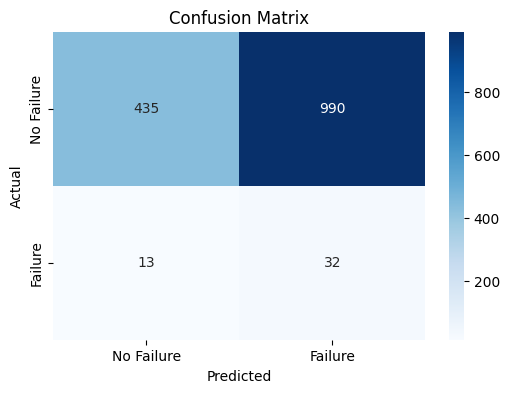

[I 2025-03-25 06:27:35,237] A new study created in memory with name: no-name-f1b7aa50-7542-464d-a9d1-424dd697cfc3



Final Test Score (Average Precision): 0.2271194282570112
Accuracy: 0.3177, Precision: 0.0313, Recall: 0.7111, F1 Score: 0.0600, AUC-ROC: 0.4996
Results saved to './modelo/model_performance_optuna_round_1.csv'

======== Round 2 of 5 ========


[I 2025-03-25 06:27:39,629] Trial 0 finished with value: 0.0028057523084524015 and parameters: {'max_depth': 5, 'learning_rate': 0.566984951147885, 'n_estimators': 393, 'min_child_weight': 0.6061223446866636, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 3.809220577048033e-08, 'reg_alpha': 4.589458612326471, 'reg_lambda': 0.010260065124896791}. Best is trial 0 with value: 0.0028057523084524015.
[I 2025-03-25 06:27:43,056] Trial 1 finished with value: 0.0018663599423816995 and parameters: {'max_depth': 8, 'learning_rate': 1.2674255898937214e-05, 'n_estimators': 488, 'min_child_weight': 663.3677136185738, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 6.8240955406304e-07, 'reg_alpha': 1.1026112761509996e-05, 'reg_lambda': 0.0017683340776662546}. Best is trial 0 with value: 0.0028057523084524015.
[I 2025-03-25 06:27:45,529] Trial 2 finished with value: 0.0018663599423816995 and parameters: {'max_depth': 6, 'learning_ra


Best Hyperparameters: {'max_depth': 4, 'learning_rate': 0.7949189115636739, 'n_estimators': 290, 'min_child_weight': 3.415982802333502, 'subsample': 0.8722779638067019, 'colsample_bytree': 0.750265237453511, 'gamma': 0.00016328708407242708, 'reg_alpha': 0.00012719237275600736, 'reg_lambda': 0.02495630126965835}
Best Validation Score: 0.227119
Total Training Time: 4074.54 seconds


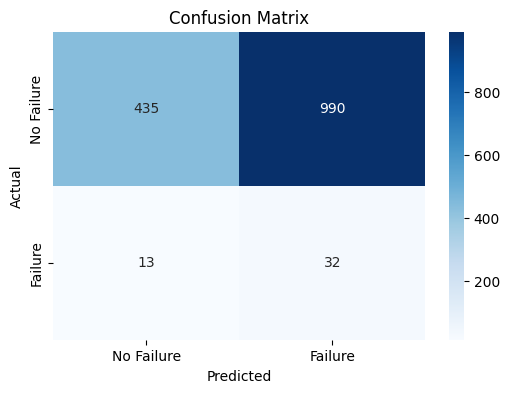

[I 2025-03-25 07:35:30,746] A new study created in memory with name: no-name-687ff46a-7e1d-4fde-932c-5812258416f3



Final Test Score (Average Precision): 0.2271194282570112
Accuracy: 0.3177, Precision: 0.0313, Recall: 0.7111, F1 Score: 0.0600, AUC-ROC: 0.4996
Results saved to './modelo/model_performance_optuna_round_2.csv'

======== Round 3 of 5 ========


[I 2025-03-25 07:35:33,199] Trial 0 finished with value: 0.0028057523084524015 and parameters: {'max_depth': 5, 'learning_rate': 0.566984951147885, 'n_estimators': 393, 'min_child_weight': 0.6061223446866636, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 3.809220577048033e-08, 'reg_alpha': 4.589458612326471, 'reg_lambda': 0.010260065124896791}. Best is trial 0 with value: 0.0028057523084524015.
[I 2025-03-25 07:35:35,290] Trial 1 finished with value: 0.0018663599423816995 and parameters: {'max_depth': 8, 'learning_rate': 1.2674255898937214e-05, 'n_estimators': 488, 'min_child_weight': 663.3677136185738, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 6.8240955406304e-07, 'reg_alpha': 1.1026112761509996e-05, 'reg_lambda': 0.0017683340776662546}. Best is trial 0 with value: 0.0028057523084524015.
[I 2025-03-25 07:35:37,939] Trial 2 finished with value: 0.0018663599423816995 and parameters: {'max_depth': 6, 'learning_ra


Best Hyperparameters: {'max_depth': 4, 'learning_rate': 0.7949189115636739, 'n_estimators': 290, 'min_child_weight': 3.415982802333502, 'subsample': 0.8722779638067019, 'colsample_bytree': 0.750265237453511, 'gamma': 0.00016328708407242708, 'reg_alpha': 0.00012719237275600736, 'reg_lambda': 0.02495630126965835}
Best Validation Score: 0.227119
Total Training Time: 3776.19 seconds


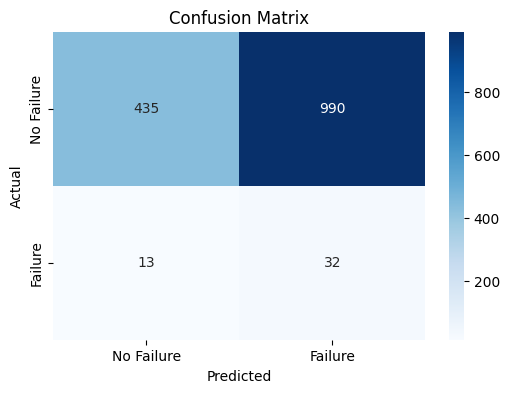

[I 2025-03-25 08:38:28,149] A new study created in memory with name: no-name-ef5ec041-a2cb-44ff-97c6-3084eeb1308d



Final Test Score (Average Precision): 0.2271194282570112
Accuracy: 0.3177, Precision: 0.0313, Recall: 0.7111, F1 Score: 0.0600, AUC-ROC: 0.4996
Results saved to './modelo/model_performance_optuna_round_3.csv'

======== Round 4 of 5 ========


[I 2025-03-25 08:38:31,857] Trial 0 finished with value: 0.0028057523084524015 and parameters: {'max_depth': 5, 'learning_rate': 0.566984951147885, 'n_estimators': 393, 'min_child_weight': 0.6061223446866636, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 3.809220577048033e-08, 'reg_alpha': 4.589458612326471, 'reg_lambda': 0.010260065124896791}. Best is trial 0 with value: 0.0028057523084524015.
[I 2025-03-25 08:38:34,977] Trial 1 finished with value: 0.0018663599423816995 and parameters: {'max_depth': 8, 'learning_rate': 1.2674255898937214e-05, 'n_estimators': 488, 'min_child_weight': 663.3677136185738, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 6.8240955406304e-07, 'reg_alpha': 1.1026112761509996e-05, 'reg_lambda': 0.0017683340776662546}. Best is trial 0 with value: 0.0028057523084524015.
[I 2025-03-25 08:38:42,498] Trial 2 finished with value: 0.0018663599423816995 and parameters: {'max_depth': 6, 'learning_ra


Best Hyperparameters: {'max_depth': 4, 'learning_rate': 0.7949189115636739, 'n_estimators': 290, 'min_child_weight': 3.415982802333502, 'subsample': 0.8722779638067019, 'colsample_bytree': 0.750265237453511, 'gamma': 0.00016328708407242708, 'reg_alpha': 0.00012719237275600736, 'reg_lambda': 0.02495630126965835}
Best Validation Score: 0.227119
Total Training Time: 3754.71 seconds


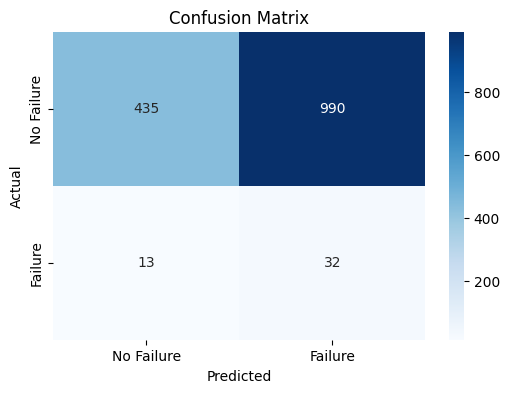

[I 2025-03-25 09:41:03,818] A new study created in memory with name: no-name-e6b5292a-72af-4cb5-90d5-0fbaeee1678e



Final Test Score (Average Precision): 0.2271194282570112
Accuracy: 0.3177, Precision: 0.0313, Recall: 0.7111, F1 Score: 0.0600, AUC-ROC: 0.4996
Results saved to './modelo/model_performance_optuna_round_4.csv'

======== Round 5 of 5 ========


[I 2025-03-25 09:41:06,360] Trial 0 finished with value: 0.0028057523084524015 and parameters: {'max_depth': 5, 'learning_rate': 0.566984951147885, 'n_estimators': 393, 'min_child_weight': 0.6061223446866636, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 3.809220577048033e-08, 'reg_alpha': 4.589458612326471, 'reg_lambda': 0.010260065124896791}. Best is trial 0 with value: 0.0028057523084524015.
[I 2025-03-25 09:41:08,341] Trial 1 finished with value: 0.0018663599423816995 and parameters: {'max_depth': 8, 'learning_rate': 1.2674255898937214e-05, 'n_estimators': 488, 'min_child_weight': 663.3677136185738, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 6.8240955406304e-07, 'reg_alpha': 1.1026112761509996e-05, 'reg_lambda': 0.0017683340776662546}. Best is trial 0 with value: 0.0028057523084524015.
[I 2025-03-25 09:41:10,889] Trial 2 finished with value: 0.0018663599423816995 and parameters: {'max_depth': 6, 'learning_ra


Best Hyperparameters: {'max_depth': 4, 'learning_rate': 0.7949189115636739, 'n_estimators': 290, 'min_child_weight': 3.415982802333502, 'subsample': 0.8722779638067019, 'colsample_bytree': 0.750265237453511, 'gamma': 0.00016328708407242708, 'reg_alpha': 0.00012719237275600736, 'reg_lambda': 0.02495630126965835}
Best Validation Score: 0.227119
Total Training Time: 3001.48 seconds


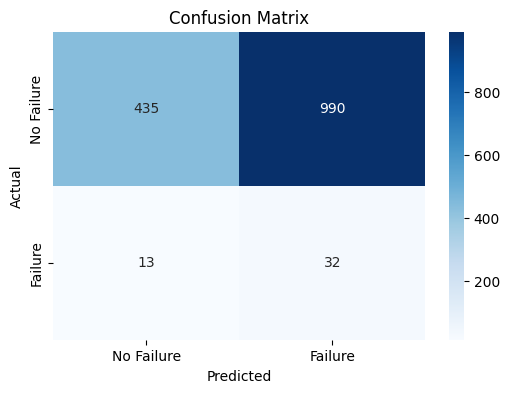


Final Test Score (Average Precision): 0.2271194282570112
Accuracy: 0.3177, Precision: 0.0313, Recall: 0.7111, F1 Score: 0.0600, AUC-ROC: 0.4996
Results saved to './modelo/model_performance_optuna_round_5.csv'

Summary of all rounds:
   round                                        best_params  \
0      1  {'max_depth': 4, 'learning_rate': 0.7949189115...   
1      2  {'max_depth': 4, 'learning_rate': 0.7949189115...   
2      3  {'max_depth': 4, 'learning_rate': 0.7949189115...   
3      4  {'max_depth': 4, 'learning_rate': 0.7949189115...   
4      5  {'max_depth': 4, 'learning_rate': 0.7949189115...   

   best_validation_score  accuracy  precision    recall        f1   roc_auc  \
0               0.227119  0.317687   0.031311  0.711111  0.059981  0.499602   
1               0.227119  0.317687   0.031311  0.711111  0.059981  0.499602   
2               0.227119  0.317687   0.031311  0.711111  0.059981  0.499602   
3               0.227119  0.317687   0.031311  0.711111  0.059981  0.49

In [12]:
num_rounds = 5
probability_threshold = 0.0001
num_trials = 1500
all_results = []

for round_num in tqdm(range(1, num_rounds + 1), desc="Optimizing rounds"):
    print(f"\n======== Round {round_num} of {num_rounds} ========")

    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 1e5),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_loguniform('gamma', 1e-8, 1e2),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1e2),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1e2),
            'objective': 'binary:logistic',
            'random_state': 42,
            'use_label_encoder': False,
            'eval_metric': 'logloss'
        }

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        val_scores = []

        try:
            for train_idx, val_idx in skf.split(X_train, y_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                clf = xgb.XGBClassifier(**params)
                clf.fit(X_tr, y_tr)
                y_pred = clf.predict_proba(X_val)[:, 1]
                y_pred[y_pred < probability_threshold] = 0
                score = average_precision_score(y_val, y_pred)
                val_scores.append(score)

            return np.mean(val_scores)

        except Exception as e:
            logging.error(f"Error during trial execution: {e}")
            return 0.0

    start_time = time.time()
    study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=num_trials)
    end_time = time.time()
    total_time = end_time - start_time

    best_config = study.best_trial.params
    best_score = study.best_value

    print("\nBest Hyperparameters:", best_config)
    print(f"Best Validation Score: {best_score:.6f}")
    print(f"Total Training Time: {total_time:.2f} seconds")

    # Train final model with best config
    final_model = xgb.XGBClassifier(**best_config, eval_metric='logloss', use_label_encoder=False)
    final_model.fit(X_train, y_train)
    y_test_proba = final_model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= probability_threshold).astype(int)

    # Metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Save result to CSV
    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC", "Total Training Time"],
        "Value": [accuracy, precision, recall, f1, roc_auc, total_time]
    })
    csv_filename = f"./modelo/model_performance_optuna_round_{round_num}.csv"
    results_df.to_csv(csv_filename, index=False)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nFinal Test Score (Average Precision):", best_score)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {roc_auc:.4f}")
    print(f"Results saved to '{csv_filename}'")

    all_results.append({
        "round": round_num,
        "best_params": best_config,
        "best_validation_score": best_score,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "total_training_time": total_time
    })

results_summary = pd.DataFrame(all_results)
print("\nSummary of all rounds:")
print(results_summary)


In [13]:
# # กำหนดจำนวนรอบที่ต้องการรัน
# num_rounds = 5

# # เก็บผลลัพธ์ของแต่ละรอบไว้ใน list
# all_results = []

# for round_num in range(1, num_rounds + 1):
#     print(f"\n======== Round {round_num} of {num_rounds} ========")
    
#     # ตั้งค่าพารามิเตอร์เพิ่มเติม
#     probability_threshold = 0.0001  # ค่า threshold สำหรับ probability

#     # เก็บค่าของ mean_val_score ในแต่ละ trial
#     val_scores_per_trial = []

#     # ฟังก์ชัน Objective สำหรับ Optuna
#     def objective_xgboost(trial):
#         params = {
#             'max_depth': trial.suggest_int('max_depth', 3, 10),
#             'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0, log=True),
#             'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#             'min_child_weight': trial.suggest_float('min_child_weight', 1e-8, 1e5, log=True),
#             'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#             'gamma': trial.suggest_float('gamma', 1e-8, 1e2, log=True),
#             'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1e2, log=True),
#             'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1e2, log=True),
#             'objective': 'binary:logistic',
#             'random_state': 42,
#             'use_label_encoder': False
#         }

#         skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#         val_scores = []

#         try:
#             for train_idx, val_idx in skf.split(X_train, y_train):
#                 X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
#                 y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

#                 # เทรน XGBoost
#                 clf = xgb.XGBClassifier(**params, eval_metric='logloss')
#                 clf.fit(X_train_fold, y_train_fold)

#                 # ทำนายผล
#                 y_val_pred = clf.predict_proba(X_val_fold)[:, 1]

#                 # กรองค่าที่ต่ำกว่า threshold
#                 y_val_pred[y_val_pred < probability_threshold] = 0

#                 # เชื่อม serial_num จาก df_train
#                 df_val = df_train.iloc[val_idx].copy()
#                 df_val['y_proba_1'] = y_val_pred
#                 df_val['max_y_proba_1'] = df_val.groupby('serial_num')['y_proba_1'].transform('max')
#                 df_val_filtered = df_val[df_val['y_proba_1'] == df_val['max_y_proba_1']].drop_duplicates(subset=['serial_num'], keep='first')

#                 # ใช้ merge() เพื่อให้ค่าจริงตรงกับ serial_num
#                 y_true_df = pd.DataFrame({'serial_num': df_train.iloc[val_idx]['serial_num'], 'y_true': y_val_fold.values})
#                 df_val_filtered = df_val_filtered.merge(y_true_df, on='serial_num', how='left')

#                 # คำนวณ Average Precision Score
#                 val_score = average_precision_score(df_val_filtered['y_true'], df_val_filtered['y_proba_1'])
#                 val_scores.append(val_score)

#             mean_val_score = np.mean(val_scores)
#             val_scores_per_trial.append(mean_val_score)  # เก็บค่า mean_val_score ของแต่ละ trial

#         except Exception as e:
#             logging.error(f'XGBClassifier: Error during trial execution: {e}')
#             raise RuntimeWarning(f"RuntimeWarning: {e}")

#         return mean_val_score

#     # เริ่มต้นจับเวลา
#     start_time = time.time()

#     # ใช้ tqdm แสดงความคืบหน้า
#     study = optuna.create_study(direction='maximize')
#     with tqdm(total=1500, desc="Optuna Tuning Progress") as pbar:
#         def callback(study, trial):
#             pbar.update(1)  # อัปเดต tqdm ทุกครั้งที่รัน trial
#         study.optimize(objective_xgboost, n_trials=1500, callbacks=[callback])

#     # บันทึกเวลาสิ้นสุด
#     end_time = time.time()
#     total_time = end_time - start_time

#     # แสดงผลพารามิเตอร์ที่ดีที่สุด
#     best_params = study.best_params
#     best_score = study.best_value
#     print("\nBest Hyperparameters:", best_params)
#     print(f"Best Validation Score: {best_score:.6f}")
#     print(f"Total Training Time: {total_time:.2f} seconds")

#     # เทรนโมเดลใหม่ด้วยพารามิเตอร์ที่ดีที่สุด
#     final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)
#     final_model.fit(X_train, y_train)

#     # ทำการพยากรณ์บนชุด Test
#     y_test_proba = final_model.predict_proba(X_test)[:, 1]

#     # แปลงเป็น 0/1 ตาม threshold
#     y_test_pred = (y_test_proba >= probability_threshold).astype(int)

#     # คำนวณ Metrics
#     accuracy = accuracy_score(y_test, y_test_pred)
#     precision = precision_score(y_test, y_test_pred)
#     recall = recall_score(y_test, y_test_pred)
#     f1 = f1_score(y_test, y_test_pred)
#     roc_auc = roc_auc_score(y_test, y_test_proba)
#     conf_matrix = confusion_matrix(y_test, y_test_pred)

#     # แสดง Confusion Matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title("Confusion Matrix")
#     plt.show()

#     # บันทึกผลลัพธ์เป็น CSV สำหรับรอบนี้ (ชื่อไฟล์มีหมายเลขรอบ)
#     results_df = pd.DataFrame({
#         "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC", "Total Training Time"],
#         "Value": [accuracy, precision, recall, f1, roc_auc, total_time]
#     })
#     csv_filename = f"./model/model_performance3_round_{round_num}.csv"
#     results_df.to_csv(csv_filename, index=False)

#     print("\nFinal Test Score (Average Precision):", best_score)
#     print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {roc_auc:.4f}")
#     print(f"Total Training Time: {total_time:.2f} seconds")
#     print(f"Results saved to '{csv_filename}'")

#     # บันทึกผลของรอบนี้ลงใน all_results
#     all_results.append({
#         "round": round_num,
#         "best_params": best_params,
#         "best_validation_score": best_score,
#         "accuracy": accuracy,
#         "precision": precision,
#         "recall": recall,
#         "f1": f1,
#         "roc_auc": roc_auc,
#         "total_training_time": total_time
#     })

# # แสดงผลสรุปรอบสุดท้าย (อาจนำไปวิเคราะห์ต่อได้)
# results_summary = pd.DataFrame(all_results)
# print("\nSummary of all rounds:")
# print(results_summary)


In [14]:
# # 🔹 ตั้งค่าพารามิเตอร์เพิ่มเติม
# probability_threshold = 0.0001  # ค่า threshold สำหรับ probability

# # 🔹 เก็บค่าของ mean_val_score ในแต่ละ trial
# val_scores_per_trial = []

# # 🔹 ฟังก์ชัน Objective สำหรับ Optuna
# def objective_xgboost(trial):
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1e-8, 1e5, log=True),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 1e-8, 1e2, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1e2, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1e2, log=True),
#         'objective': 'binary:logistic',
#         'random_state': 42,
#         'use_label_encoder': False
#     }

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     val_scores = []

#     try:
#         for train_idx, val_idx in skf.split(X_train, y_train):
#             X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
#             y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

#             # เทรน XGBoost
#             clf = xgb.XGBClassifier(**params, eval_metric='logloss')
#             clf.fit(X_train_fold, y_train_fold)

#             # ทำนายผล
#             y_val_pred = clf.predict_proba(X_val_fold)[:, 1]

#             # กรองค่าที่ต่ำกว่า threshold
#             y_val_pred[y_val_pred < probability_threshold] = 0

#             # เชื่อม serial_num จาก df_train
#             df_val = df_train.iloc[val_idx].copy()
#             df_val['y_proba_1'] = y_val_pred
#             df_val['max_y_proba_1'] = df_val.groupby('serial_num')['y_proba_1'].transform('max')
#             df_val_filtered = df_val[df_val['y_proba_1'] == df_val['max_y_proba_1']].drop_duplicates(subset=['serial_num'], keep='first')

#             # ✅ ใช้ merge() เพื่อให้ค่าจริงตรงกับ serial_num
#             y_true_df = pd.DataFrame({'serial_num': df_train.iloc[val_idx]['serial_num'], 'y_true': y_val_fold.values})
#             df_val_filtered = df_val_filtered.merge(y_true_df, on='serial_num', how='left')

#             # คำนวณ Average Precision Score
#             val_score = average_precision_score(df_val_filtered['y_true'], df_val_filtered['y_proba_1'])
#             val_scores.append(val_score)

#         mean_val_score = np.mean(val_scores)
#         val_scores_per_trial.append(mean_val_score)  # 🔹 เก็บค่า mean_val_score ของแต่ละ trial

#     except Exception as e:
#         logging.error(f'XGBClassifier: Error during trial execution: {e}')
#         raise RuntimeWarning(f"RuntimeWarning: {e}")

#     return mean_val_score

# # 🔹 เริ่มต้นจับเวลา
# start_time = time.time()

# # 🔹 ใช้ tqdm แสดงความคืบหน้า
# study = optuna.create_study(direction='maximize')
# with tqdm(total=1500, desc="Optuna Tuning Progress") as pbar:
#     def callback(study, trial):
#         pbar.update(1)  # อัปเดต tqdm ทุกครั้งที่รัน trial
#     study.optimize(objective_xgboost, n_trials=1500, callbacks=[callback])

# # 🔹 บันทึกเวลาสิ้นสุด
# end_time = time.time()
# total_time = end_time - start_time

# # 🔹 แสดงผลพารามิเตอร์ที่ดีที่สุด
# best_params = study.best_params
# best_score = study.best_value
# print("\nBest Hyperparameters:", best_params)
# print(f"Best Validation Score: {best_score:.6f}")
# print(f"Total Training Time: {total_time:.2f} seconds")

# # 🔹 เทรนโมเดลใหม่ด้วยพารามิเตอร์ที่ดีที่สุด
# final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)
# final_model.fit(X_train, y_train)

# # 🔹 ทำการพยากรณ์บนชุด Test
# y_test_proba = final_model.predict_proba(X_test)[:, 1]

# # 🔹 แปลงเป็น 0/1 ตาม threshold
# y_test_pred = (y_test_proba >= probability_threshold).astype(int)

# # 🔹 คำนวณ Metrics
# accuracy = accuracy_score(y_test, y_test_pred)
# precision = precision_score(y_test, y_test_pred)
# recall = recall_score(y_test, y_test_pred)
# f1 = f1_score(y_test, y_test_pred)
# roc_auc = roc_auc_score(y_test, y_test_proba)
# conf_matrix = confusion_matrix(y_test, y_test_pred)

# # 🔹 แสดง Confusion Matrix
# plt.figure(figsize=(6, 4))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# # 🔹 บันทึกผลลัพธ์เป็น CSV รวมเวลาการรันทั้งหมด
# results_df = pd.DataFrame({
#     "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC", "Total Training Time"],
#     "Value": [accuracy, precision, recall, f1, roc_auc, total_time]
# })
# results_df.to_csv("./model/model_performance3.csv", index=False)

# print("\nFinal Test Score (Average Precision):", best_score)
# print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {roc_auc:.4f}")
# print(f"Total Training Time: {total_time:.2f} seconds")
# print("Results saved to 'model_performance3.csv'")


In [15]:
# # --- ตั้งค่าพารามิเตอร์เพิ่มเติม
# probability_threshold = 0.0001  # ค่า threshold สำหรับ probability

# # --- กำหนด search space สำหรับ hyperparameter
# search_space = {
#     "max_depth": {"domain": (3, 10), "init_value": 6, "integer": True},
#     "learning_rate": {"domain": [1e-5, 1.0], "init_value": 0.1, "log": True},
#     "n_estimators": {"domain": (100, 500), "init_value": 300, "integer": True},
#     "min_child_weight": {"domain": [1e-8, 1e5], "init_value": 1, "log": True},
#     "subsample": {"domain": (0.5, 1.0), "init_value": 0.8},
#     "colsample_bytree": {"domain": (0.5, 1.0), "init_value": 0.8},
#     "gamma": {"domain": [1e-8, 1e2], "init_value": 0, "log": True},
#     "reg_alpha": {"domain": [1e-8, 1e2], "init_value": 0, "log": True},
#     "reg_lambda": {"domain": [1e-8, 1e2], "init_value": 1, "log": True},
# }

# # --- ใช้ OptunaSearch ของ FLAML
# from flaml.searcher.optuna_search import OptunaSearch

# # --- ฟังก์ชัน Objective สำหรับ OptunaSearch
# def objective_xgboost_optuna(params):
#     # ผนวกค่าที่ได้จาก searcher กับค่าคงที่
#     full_params = params.copy()
#     full_params.update({
#         'objective': 'binary:logistic',
#         'random_state': 42,
#         'use_label_encoder': False
#     })
    
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     val_scores = []
    
#     try:
#         for train_idx, val_idx in skf.split(X_train, y_train):
#             X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
#             y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
#             # เทรน XGBoost
#             clf = xgb.XGBClassifier(**full_params, eval_metric='logloss')
#             clf.fit(X_train_fold, y_train_fold)
            
#             # ทำนายผล
#             y_val_pred = clf.predict_proba(X_val_fold)[:, 1]
#             # กรองค่าที่ต่ำกว่า threshold
#             y_val_pred[y_val_pred < probability_threshold] = 0
            
#             # เชื่อม serial_num จาก df_train
#             df_val = df_train.iloc[val_idx].copy()
#             df_val['y_proba_1'] = y_val_pred
#             df_val['max_y_proba_1'] = df_val.groupby('serial_num')['y_proba_1'].transform('max')
#             df_val_filtered = df_val[df_val['y_proba_1'] == df_val['max_y_proba_1']].drop_duplicates(subset=['serial_num'], keep='first')
            
#             # ใช้ merge() เพื่อให้ค่าจริงตรงกับ serial_num
#             y_true_df = pd.DataFrame({
#                 'serial_num': df_train.iloc[val_idx]['serial_num'],
#                 'y_true': y_val_fold.values
#             })
#             df_val_filtered = df_val_filtered.merge(y_true_df, on='serial_num', how='left')
            
#             # คำนวณ Average Precision Score
#             val_score = average_precision_score(df_val_filtered['y_true'], df_val_filtered['y_proba_1'])
#             val_scores.append(val_score)
            
#         mean_val_score = np.mean(val_scores)
#         return mean_val_score
    
#     except Exception as e:
#         logging.error(f'XGBClassifier: Error during trial execution: {e}')
#         raise RuntimeWarning(f"RuntimeWarning: {e}")

# # --- จำนวนรอบและ trial ต่อรอบ
# n_rounds = 10
# n_trials = 1500

# for run in range(1, n_rounds+1):
#     print(f"\n========== เริ่มการรันรอบที่ {run} ==========")
    
#     # เริ่มจับเวลาในแต่ละรอบ
#     start_time = time.time()
    
#     # สร้าง searcher ใหม่สำหรับแต่ละรอบ
#     searcher = OptunaSearch(search_space, metric="val_score", mode="max")
    
#     # ใช้ OptunaSearch ผ่านการวนลูป trial แบบ manual พร้อมแสดงความคืบหน้าด้วย tqdm
#     best_score = -np.inf
#     best_params = None
#     pbar = tqdm(total=n_trials, desc=f"OptunaSearch Tuning Progress Run {run}")
    
#     for trial_num in range(n_trials):
#         trial_config = searcher.next_trial()
#         score = objective_xgboost_optuna(trial_config)
#         searcher.update_trial(trial_config, score)
        
#         if score > best_score:
#             best_score = score
#             best_params = trial_config
        
#         pbar.update(1)
#     pbar.close()
    
#     # บันทึกเวลาที่ใช้ในแต่ละรอบ
#     end_time = time.time()
#     total_time = end_time - start_time
    
#     print(f"\n[Run {run}] Best Hyperparameters:", best_params)
#     print(f"[Run {run}] Best Validation Score (Average Precision): {best_score:.6f}")
#     print(f"[Run {run}] Total Tuning Time: {total_time:.2f} seconds")
    
#     # --- เทรน final model ด้วยพารามิเตอร์ที่ดีที่สุดบนข้อมูลเต็ม
#     final_params = best_params.copy()
#     final_params.update({
#         'objective': 'binary:logistic',
#         'random_state': 42,
#         'use_label_encoder': False
#     })
#     final_model = xgb.XGBClassifier(**final_params, eval_metric='logloss')
#     final_model.fit(X_train, y_train)
    
#     # ทำนายผลบนชุด Test และคำนวณ Metrics
#     y_test_proba = final_model.predict_proba(X_test)[:, 1]
#     y_test_pred = (y_test_proba >= probability_threshold).astype(int)
    
#     accuracy = accuracy_score(y_test, y_test_pred)
#     precision = precision_score(y_test, y_test_pred)
#     recall = recall_score(y_test, y_test_pred)
#     f1 = f1_score(y_test, y_test_pred)
#     roc_auc = roc_auc_score(y_test, y_test_proba)
#     conf_matrix = confusion_matrix(y_test, y_test_pred)
    
#     # แสดง Confusion Matrix
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#                 xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title(f"OptunaSearch Confusion Matrix Run {run}")
#     plt.show()
    
#     # บันทึกผลลัพธ์เป็น CSV โดยใช้ชื่อไฟล์ไม่ซ้ำกัน
#     results_df = pd.DataFrame({
#         "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC", "Total Tuning Time"],
#         "Value": [accuracy, precision, recall, f1, roc_auc, total_time]
#     })
#     output_filename = f"./model/model_performance4_run{run}.csv"
#     results_df.to_csv(output_filename, index=False)
    
#     print(f"\n[Run {run}] Final Test Score (Average Precision): {best_score:.6f}")
#     print(f"[Run {run}] Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {roc_auc:.4f}")
#     print(f"[Run {run}] Total Tuning Time: {total_time:.2f} seconds")
#     print(f"[Run {run}] Results saved to '{output_filename}'")

In [16]:

# accuracy = accuracy_score(y_test, y_test_pred)
# precision = precision_score(y_test, y_test_pred)
# recall = recall_score(y_test, y_test_pred)
# f1 = f1_score(y_test, y_test_pred)
# roc_auc = roc_auc_score(y_test, y_test_proba)
# conf_matrix = confusion_matrix(y_test, y_test_pred)

# # 🔹 แสดง Confusion Matrix
# plt.figure(figsize=(6, 4))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()


In [17]:
# # 🔹 บันทึก Confusion Matrix เป็นไฟล์ PNG
# plt.figure(figsize=(6, 4))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")

# # 🔹 บันทึกเป็นไฟล์
# plt.savefig("./model/confusion_matrix3.png", dpi=300, bbox_inches='tight')
# plt.show()

# print("Confusion Matrix saved to 'model/confusion_matrix.png'")


In [18]:
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve
from sklearn.inspection import PartialDependenceDisplay


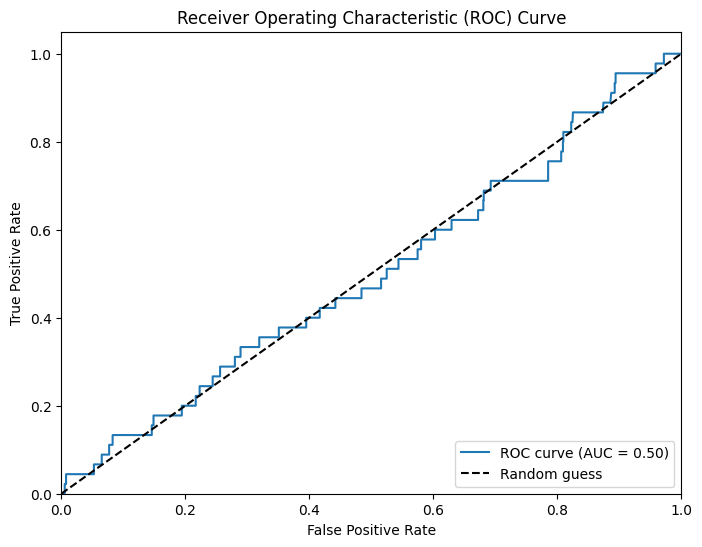

In [19]:
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    f1_score
)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


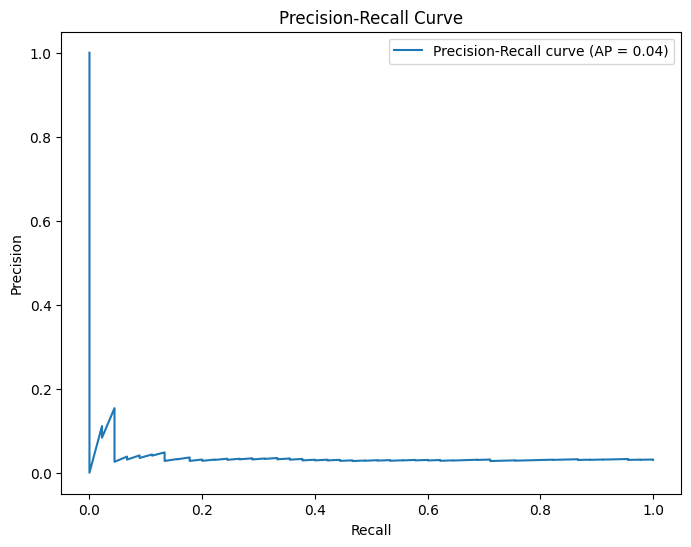

In [20]:
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_test_proba)
average_precision = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


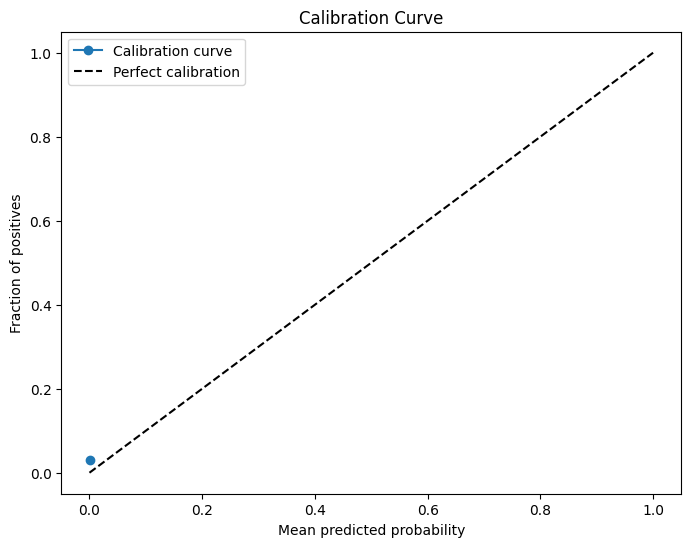

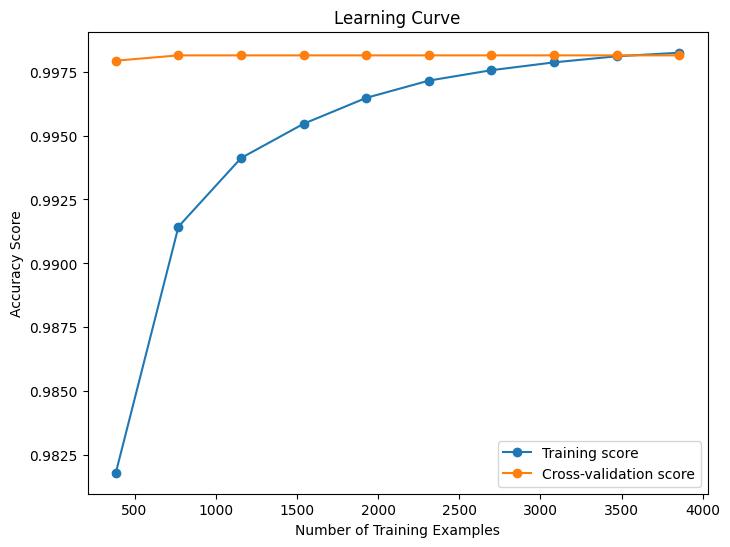

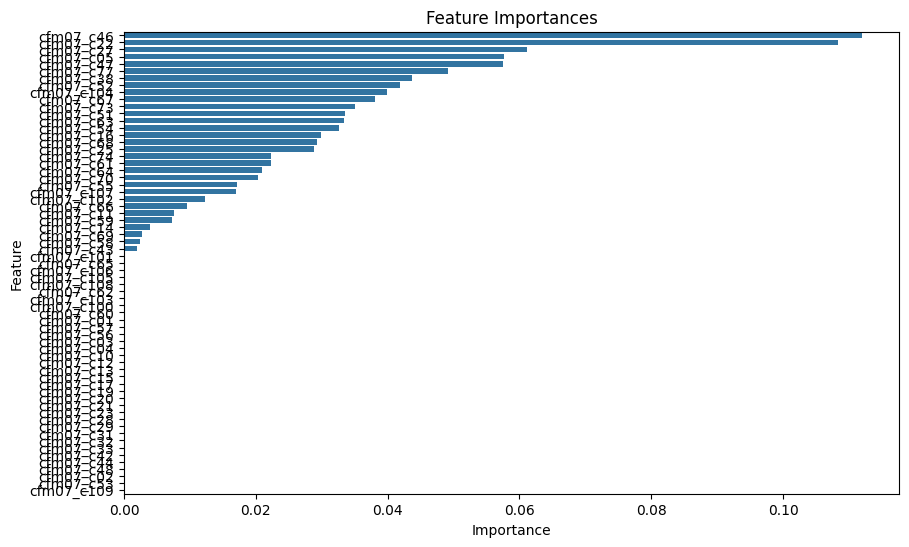

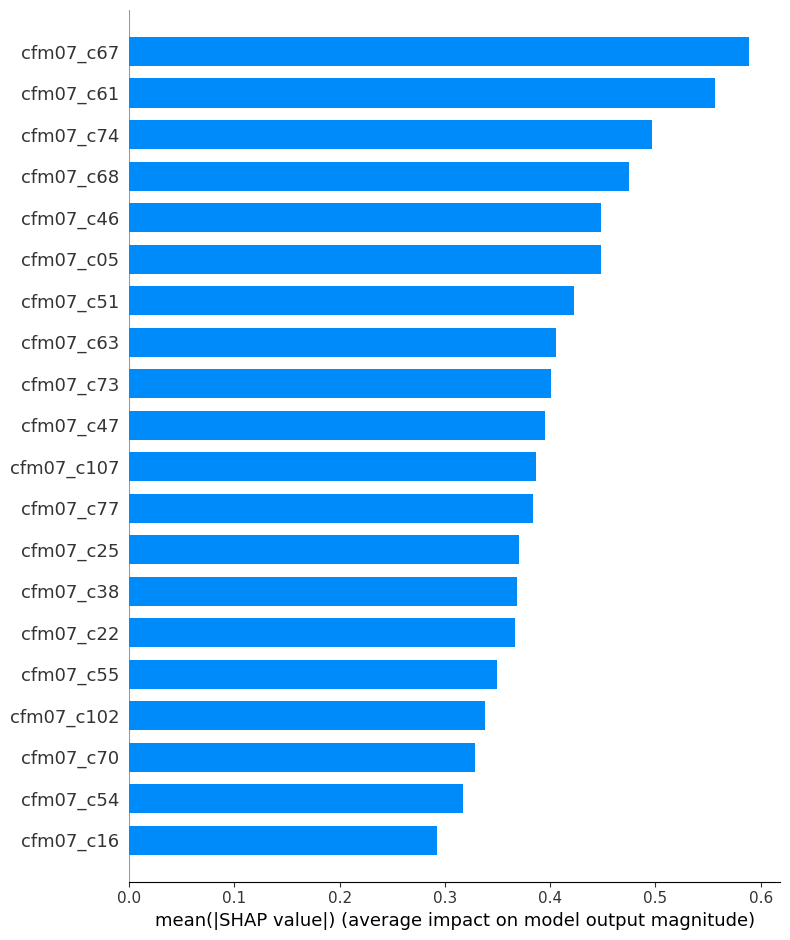

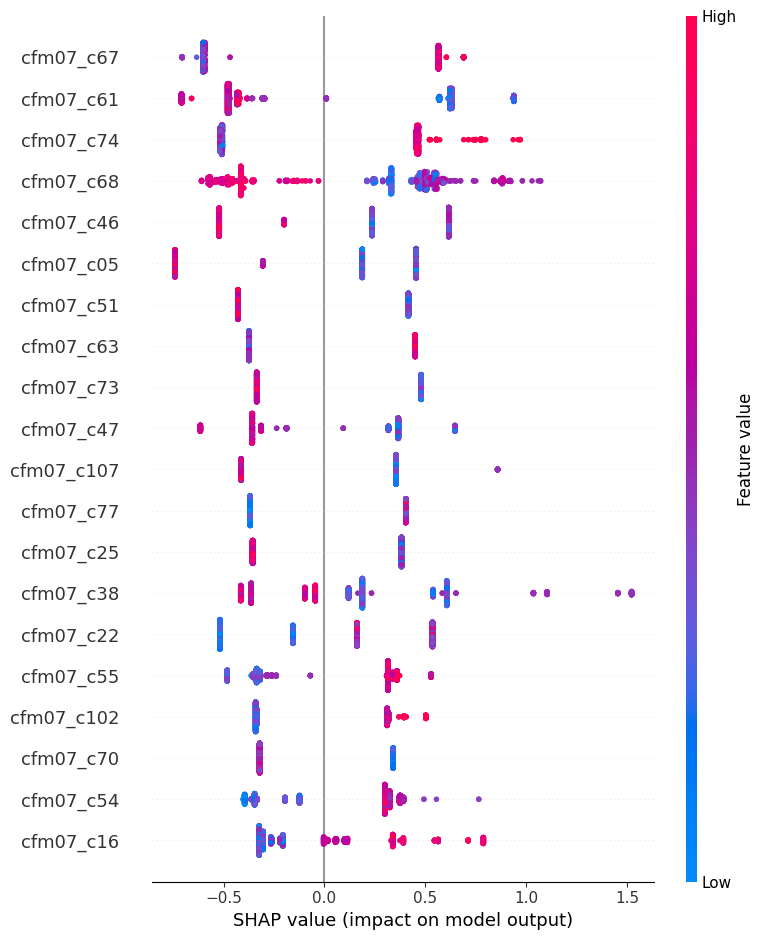

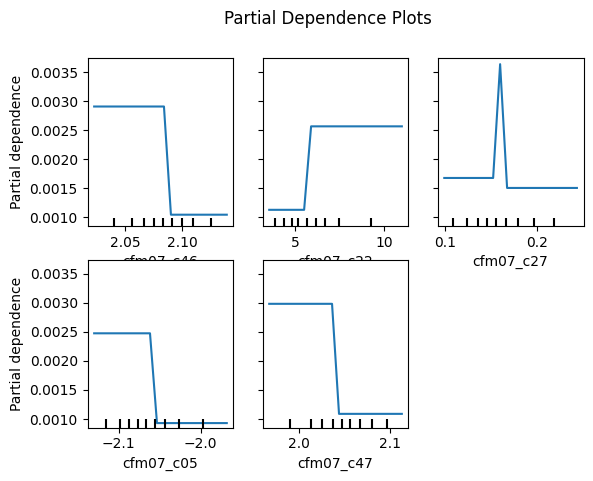

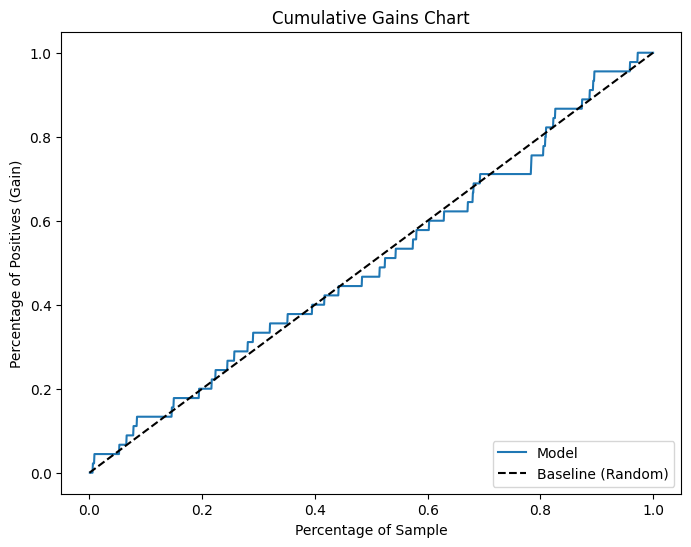

In [21]:
prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend(loc='upper left')
plt.show()

# -----------------------------------------------------
# 4. Learning Curve
# -----------------------------------------------------
# คำนวณ learning curve จากข้อมูล training
train_sizes, train_scores, cv_scores = learning_curve(
    final_model, X_train, y_train, cv=5, scoring='accuracy',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)
train_scores_mean = np.mean(train_scores, axis=1)
cv_scores_mean = np.mean(cv_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, cv_scores_mean, 'o-', label="Cross-validation score")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# -----------------------------------------------------
# 5. Feature Importance (สำหรับ XGBoost)
# -----------------------------------------------------
# สมมติว่า X_train เป็น DataFrame และ final_model มี attribute feature_importances_
importances = final_model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# -----------------------------------------------------
# 6. SHAP Values (อธิบายโมเดลเชิง instance-level)
# -----------------------------------------------------
# (ต้องติดตั้ง library shap ด้วยคำสั่ง pip install shap หากยังไม่ได้ติดตั้ง)
try:
    import shap
    # สร้าง TreeExplainer สำหรับโมเดล XGBoost
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test)

    # Summary Plot แบบ bar chart (feature importance จากมุมมองของ SHAP)
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    # Summary Plot แบบ beeswarm เพื่อดูผลกระทบของแต่ละฟีเจอร์ในทุกตัวอย่าง
    shap.summary_plot(shap_values, X_test)
except ImportError:
    print("SHAP library not installed. Please install it using 'pip install shap'.")

# -----------------------------------------------------
# 7. Partial Dependence Plots (PDP)
# -----------------------------------------------------
# แสดง PDP สำหรับฟีเจอร์ที่สำคัญ 5 ตัวแรก (หรือเลือกฟีเจอร์ตามที่ต้องการ)
features_to_plot = importance_df['Feature'].head(5).tolist()
PartialDependenceDisplay.from_estimator(final_model, X_train, features_to_plot, kind='average', grid_resolution=20)
plt.suptitle("Partial Dependence Plots")
plt.show()

# -----------------------------------------------------
# 8. Cumulative Gains Chart (Lift/Gain Chart)
# -----------------------------------------------------
df_gain = pd.DataFrame({'y_true': y_test, 'y_proba': y_test_proba})
df_gain = df_gain.sort_values(by='y_proba', ascending=False).reset_index(drop=True)
df_gain['cumulative_positives'] = df_gain['y_true'].cumsum()
df_gain['sample_percentage'] = np.arange(1, len(df_gain) + 1) / len(df_gain)
total_positives = df_gain['y_true'].sum()
df_gain['gain'] = df_gain['cumulative_positives'] / total_positives

plt.figure(figsize=(8, 6))
plt.plot(df_gain['sample_percentage'], df_gain['gain'], label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline (Random)')
plt.xlabel('Percentage of Sample')
plt.ylabel('Percentage of Positives (Gain)')
plt.title('Cumulative Gains Chart')
plt.legend(loc='lower right')
plt.show()

In [22]:
# pip list

In [23]:
# # 🔹 ตั้งค่าพารามิเตอร์เพิ่มเติม
# probability_threshold = 0.0001  # ค่า threshold สำหรับ probability

# # 🔹 เก็บค่าของ mean_val_score ในแต่ละ trial
# val_scores_per_trial = []

# # 🔹 ฟังก์ชัน Objective สำหรับ Optuna
# def objective_xgboost(trial):
#     """
#     Objective function สำหรับ Optuna เพื่อค้นหา hyperparameters ของ XGBoost
#     โดยใช้ StratifiedKFold (5-fold) และประเมินด้วย Average Precision Score
#     """
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1e-8, 1e5, log=True),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 1e-8, 1e2, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1e2, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1e2, log=True),
#         'objective': 'binary:logistic',
#         'random_state': 42,
#         'use_label_encoder': False,
#         'eval_metric': 'logloss',  # กำหนด metric สำหรับ XGBClassifier
#     }

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     val_scores = []

#     try:
#         for train_idx, val_idx in skf.split(X_train, y_train):
#             X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
#             y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

#             # 🔹 เทรน XGBoost โดยใช้ Callback สำหรับ Early Stopping
#             clf = xgb.XGBClassifier(**params)
#             clf.fit(
#                 X_train_fold,
#                 y_train_fold,
#                 eval_set=[(X_val_fold, y_val_fold)],
#                 callbacks=[EarlyStopping(rounds=20)],  # ใช้ Callback แทน early_stopping_rounds
#                 verbose=False
#             )

#             # 🔹 ทำนายผล (Probabilities)
#             y_val_proba = clf.predict_proba(X_val_fold)[:, 1]

#             # 🔹 กรองค่าที่ต่ำกว่า threshold ให้เป็น 0
#             y_val_proba[y_val_proba < probability_threshold] = 0

#             # 🔹 สร้าง df_val จาก df_train ส่วน val_idx
#             df_val = df_train.iloc[val_idx].copy()
#             df_val['y_proba_1'] = y_val_proba

#             # 🔹 เลือก max probability ต่อ serial_num
#             df_val['max_y_proba_1'] = df_val.groupby('serial_num')['y_proba_1'].transform('max')
#             df_val_filtered = df_val[df_val['y_proba_1'] == df_val['max_y_proba_1']].drop_duplicates(
#                 subset=['serial_num'],
#                 keep='first'
#             )

#             # 🔹 Merge เพื่อให้ได้ y_true
#             y_true_df = pd.DataFrame({
#                 'serial_num': df_train.iloc[val_idx]['serial_num'],
#                 'y_true': y_val_fold.values
#             })
#             df_val_filtered = df_val_filtered.merge(y_true_df, on='serial_num', how='left')

#             # 🔹 คำนวณ Average Precision Score
#             val_score = average_precision_score(df_val_filtered['y_true'], df_val_filtered['y_proba_1'])
#             val_scores.append(val_score)

#         mean_val_score = np.mean(val_scores)
#         val_scores_per_trial.append(mean_val_score)

#     except Exception as e:
#         logging.error(f'XGBClassifier: Error during trial execution: {e}')
#         raise RuntimeWarning(f"RuntimeWarning: {e}")

#     return mean_val_score


# # 🔹 เริ่มต้นจับเวลา
# start_time = time.time()

# # 🔹 สร้าง Study ของ Optuna โดยใช้ Sampler + Pruner
# study = optuna.create_study(
#     direction='maximize',
#     sampler=TPESampler(seed=42),
#     pruner=MedianPruner(n_warmup_steps=5)
# )

# # 🔹 ใช้ tqdm แสดงความคืบหน้า
# n_trials = 1500
# with tqdm(total=n_trials, desc="Optuna Tuning Progress") as pbar:
#     def callback(study, trial):
#         pbar.update(1)
#     study.optimize(objective_xgboost, n_trials=n_trials, callbacks=[callback])

# # 🔹 บันทึกเวลาสิ้นสุด
# end_time = time.time()
# total_time = end_time - start_time

# # 🔹 แสดงผลพารามิเตอร์ที่ดีที่สุด
# best_params = study.best_params
# best_score = study.best_value
# print("\nBest Hyperparameters:", best_params)
# print(f"Best Validation Score (Average Precision): {best_score:.6f}")
# print(f"Total Training Time: {total_time:.2f} seconds")

# # 🔹 เทรนโมเดลใหม่ด้วยพารามิเตอร์ที่ดีที่สุด
# final_model = xgb.XGBClassifier(
#     **best_params,
#     eval_metric='logloss',
#     use_label_encoder=False
# )

# # (ถ้าต้องการ Early Stopping รอบสุดท้ายด้วย ให้กำหนด eval_set และ callback อีกครั้ง)
# final_model.fit(
#     X_train,
#     y_train
#     # eval_set=[(X_val, y_val)],
#     # callbacks=[EarlyStopping(rounds=20)]
# )

# # 🔹 ทำนายผลบนชุด Test (Probabilities)
# y_test_proba = final_model.predict_proba(X_test)[:, 1]

# # ------------------------------------------------------------------------------------
# # 🔹 ทำขั้นตอนเดียวกับใน CV: จัดการ df_test ให้ตรงกับ X_test, y_test
# # ------------------------------------------------------------------------------------
# df_test_temp = df_test.iloc[X_test.index].copy()  # เผื่อให้ index ตรงกัน
# df_test_temp['y_proba_1'] = y_test_proba

# # 🔹 กรองค่าที่ต่ำกว่า threshold ให้เป็น 0
# df_test_temp.loc[df_test_temp['y_proba_1'] < probability_threshold, 'y_proba_1'] = 0

# # 🔹 เลือก max probability ต่อ serial_num
# df_test_temp['max_y_proba_1'] = df_test_temp.groupby('serial_num')['y_proba_1'].transform('max')
# df_test_filtered = df_test_temp[df_test_temp['y_proba_1'] == df_test_temp['max_y_proba_1']].drop_duplicates(
#     subset=['serial_num'],
#     keep='first'
# )

# # 🔹 Merge เพื่อให้ได้ y_true
# y_test_df = pd.DataFrame({
#     'serial_num': df_test_temp['serial_num'],
#     'y_true': y_test.values
# })
# df_test_filtered = df_test_filtered.merge(y_test_df, on='serial_num', how='left')

# # 🔹 Threshold เป็น 0/1 (เก็บลงคอลัมน์ y_pred)
# df_test_filtered['y_pred'] = (df_test_filtered['y_proba_1'] >= probability_threshold).astype(int)

# # 🔹 คำนวณ Metrics
# accuracy = accuracy_score(df_test_filtered['y_true'], df_test_filtered['y_pred'])
# precision = precision_score(df_test_filtered['y_true'], df_test_filtered['y_pred'])
# recall = recall_score(df_test_filtered['y_true'], df_test_filtered['y_pred'])
# f1 = f1_score(df_test_filtered['y_true'], df_test_filtered['y_pred'])
# roc_auc = roc_auc_score(df_test_filtered['y_true'], df_test_filtered['y_proba_1'])
# conf_matrix = confusion_matrix(df_test_filtered['y_true'], df_test_filtered['y_pred'])

# # 🔹 แสดง Confusion Matrix
# plt.figure(figsize=(6, 4))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=["No Failure", "Failure"],
#             yticklabels=["No Failure", "Failure"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# # 🔹 บันทึกผลลัพธ์เป็น CSV รวมเวลาการรันทั้งหมด
# results_df = pd.DataFrame({
#     "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC", "Total Training Time"],
#     "Value": [accuracy, precision, recall, f1, roc_auc, total_time]
# })
# results_df.to_csv("./model/model_performance3.csv", index=False)

# # 🔹 แสดงผลลัพธ์
# print(f"\nFinal Test Score (Average Precision) [from best_params]: {best_score:.6f}")
# print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {roc_auc:.4f}")
# print(f"Total Training Time: {total_time:.2f} seconds")
# print("Results saved to 'model_performance3.csv'")


In [24]:
# import numpy as np
# import pandas as pd
# import xgboost as xgb
# from sklearn.metrics import accuracy_score, f1_score
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import StratifiedKFold

# # ✅ ตรวจสอบว่า y_train เป็น numpy array
# if isinstance(y_train, pd.Series):
#     y_train = y_train.to_numpy()

# # ✅ คำนวณจำนวนตัวอย่างของแต่ละ Class
# num_class_0 = np.sum(y_train == 0)
# num_class_1 = np.sum(y_train == 1)

# # ✅ แปลงให้เป็น float ก่อนใช้
# scale_pos_weight = float(num_class_0) / float(num_class_1)

# print(f"✅ scale_pos_weight: {scale_pos_weight:.2f}")

# # ตั้งค่า Stratified K-Fold
# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# # เก็บผลลัพธ์ของแต่ละ Fold
# fold_data = []

# for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train), 1):
#     X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
#     y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

#     # ✅ แปลง y_train ให้เป็น 1D Array
#     y_train_fold_np = y_train_fold.to_numpy().ravel()
#     y_val_fold_np = y_val_fold.to_numpy().ravel()

#     # ✅ ใช้ `scale_pos_weight` ใน XGBoost
#     model = xgb.XGBClassifier(
#         objective='binary:logistic',
#         eval_metric='logloss',
#         scale_pos_weight=scale_pos_weight,
#         use_label_encoder=False,
#         random_state=42
#     )

#     # Train โมเดล
#     model.fit(X_train_fold, y_train_fold_np)

#     # ทำนายผล
#     y_pred = model.predict(X_val_fold)

#     # คำนวณ Accuracy และ F1 Score
#     accuracy = accuracy_score(y_val_fold_np, y_pred)
#     f1 = f1_score(y_val_fold_np, y_pred, zero_division=1)

#     # แสดงผลลัพธ์ของแต่ละ Fold
#     print(f"🔹 Fold {fold}")
#     print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
#     print("-" * 50)

#     # ✅ เก็บข้อมูลแต่ละ Fold
#     fold_data.append({
#         "Fold": fold,
#         "Accuracy": accuracy,
#         "F1 Score": f1,
#         "Train Class 0 Ratio": np.mean(y_train_fold_np == 0),
#         "Train Class 1 Ratio": np.mean(y_train_fold_np == 1),
#         "Test Class 0 Ratio": np.mean(y_val_fold_np == 0),
#         "Test Class 1 Ratio": np.mean(y_val_fold_np == 1),
#     })

# # ✅ แสดงข้อมูลทุก Fold เป็น DataFrame
# df_folds = pd.DataFrame(fold_data)

# # ✅ บันทึกลง CSV
# df_folds.to_csv("xgboost_results.csv", index=False)
# print("✅ Results saved to 'xgboost_results.csv'")

# # ✅ แสดง DataFrame
# print(df_folds)


In [25]:
# import numpy as np
# import pandas as pd
# import xgboost as xgb
# from sklearn.metrics import accuracy_score, f1_score
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import StratifiedKFold
# from imblearn.over_sampling import SMOTE

# # ✅ คำนวณ class weight
# num_class_0 = np.sum(y_train == 0)
# num_class_1 = np.sum(y_train == 1)
# scale_pos_weight = (num_class_0 / num_class_1) * 5  # เพิ่มน้ำหนักให้ Class 1

# print(f"✅ scale_pos_weight: {scale_pos_weight:.2f}")

# # ✅ ใช้ SMOTE Oversampling
# smote = SMOTE(sampling_strategy=0.1, random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # ✅ ตั้งค่า Stratified K-Fold (ใช้ 5 Folds)
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# fold_data = []

# for fold, (train_index, test_index) in enumerate(skf.split(X_train_resampled, y_train_resampled), 1):
#     X_train_fold, X_val_fold = X_train_resampled.iloc[train_index], X_train_resampled.iloc[test_index]
#     y_train_fold, y_val_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[test_index]

#     # ✅ ใช้ `scale_pos_weight` และปรับพารามิเตอร์ของ XGBoost
#     model = xgb.XGBClassifier(
#         objective='binary:logistic',
#         eval_metric='logloss',
#         scale_pos_weight=scale_pos_weight,
#         max_depth=6,
#         min_child_weight=1,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         learning_rate=0.05,
#         n_estimators=500,
#         use_label_encoder=False,
#         random_state=42
#     )

#     # Train โมเดล
#     model.fit(X_train_fold, y_train_fold)

#     # ทำนายผล
#     y_pred = model.predict(X_val_fold)

#     # คำนวณ Accuracy และ F1 Score
#     accuracy = accuracy_score(y_val_fold, y_pred)
#     f1 = f1_score(y_val_fold, y_pred, zero_division=1)

#     # ✅ เก็บข้อมูลแต่ละ Fold
#     fold_data.append({
#         "Fold": fold,
#         "Accuracy": accuracy,
#         "F1 Score": f1,
#         "Train Class 0 Ratio": np.mean(y_train_fold == 0),
#         "Train Class 1 Ratio": np.mean(y_train_fold == 1),
#         "Test Class 0 Ratio": np.mean(y_val_fold == 0),
#         "Test Class 1 Ratio": np.mean(y_val_fold == 1),
#     })

# # ✅ แสดงข้อมูลทุก Fold เป็น DataFrame
# df_folds = pd.DataFrame(fold_data)
# df_folds.to_csv("xgboost_results.csv", index=False)
# print("✅ Results saved to 'xgboost_results.csv'")
# print(df_folds)


In [26]:
# from IPython.display import display
# display(df_folds)


In [27]:
# !pip list
